In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from scipy.stats import binom
import matplotlib as mpl
from sklearn import datasets
import itertools

In [2]:
X_0 = np.random.rand(30,2) + 1
X_1 = np.random.rand(30,2) - 1
X = np.concatenate([X_0, X_1])

#X = datasets.make_moons(n_samples=100, noise=0.05)[0].astype(np.float32)
#X = datasets.make_blobs(n_samples=100, centers=3)[0].astype(np.float32)
#np.random.shuffle(X)

In [3]:
def L2_dist(a, b):
    return np.linalg.norm(a-b)

In [4]:
def compute_G0(X, d=L2_dist):
    W = np.zeros((len(X), len(X)))
    for i in range(len(X)-1):
        for j in range(i+1, len(X)):
            W[i, j] = d(X[i], X[j])
            W[j, i] = d(X[i], X[j])
    D_sqinv = np.diag(np.sum(W, axis=0) ** -0.5)
    return W, D_sqinv

In [5]:
W, D_sqinv = compute_G0(X)

In [6]:
def compute_laplacian(W, D_sqinv):
    return np.eye(len(W)) - D_sqinv @ W @ D_sqinv

In [7]:
L = compute_laplacian(W, D_sqinv)

In [8]:
def compute_AM_normalised(L, D_sqinv, M=len(L)):
    V, A = np.linalg.eig(L)
    V = 1 - V
    idx = V.argsort()  
    V = V[idx]
    A = A[:,idx]
    V = np.diag(V)
    A = A[:, :M]
    return D_sqinv @ A

In [9]:
A = compute_AM_normalised(L, D_sqinv, 3)

In [10]:
class Graph:
    def __init__(self, vertices):
        self.V = vertices
        self.graph = []
        self.hierarchy = None
        self.A = None
        self.omega = 0

    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])
        self.omega += w

    # Search function, ça trouve un point fixe en fait, en partant de celui qu'on veut

    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    def apply_union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    #  Applying Kruskal algorithm
    def kruskal_algo(self):
        result = []
        hierarchy = []
        i, e = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2])
        rank = [0] * self.V
        parent = list(range(self.V))
        while e < self.V - 1:
            u, v, w = self.graph[i]
            i += 1
            x = self.find(parent, u)
            y = self.find(parent, v)
            if x != y:
                e += 1
                result.append([u, v, w])
                self.apply_union(parent, rank, x, y)
                hierarchy.append(result.copy())
        self.hierarchy = hierarchy
        return hierarchy
            
        
    def compute_A(self):
        A = np.zeros((g.V, g.V))
        for e in g.graph:
            A[e[0], e[1]] = e[2]
            A[e[1], e[0]] = e[2]
        self.A = A

    def cross_sum(self, A, l1, l2):
        return np.sum((A * l1).T * l2)
    
    
    def compute_mat(self):
        A = self.A
        mat = np.zeros((2 * self.V - 1, self.V + 6))
        for i in range(self.V):
            mat[i, 5] = 1
            mat[i, i + 6] = 1
        hierarchy = self.hierarchy
        l_buf = list(range(self.V))
        for i, e in enumerate(hierarchy[-1]):
            u, v, _ = e
            j = i + self.V
            mat[l_buf[u], 0] = j
            mat[l_buf[v], 0] = j
            mat[l_buf[u], 1] = l_buf[v]
            mat[l_buf[v], 1] = l_buf[u]
            mat[j, 2] = l_buf[u]
            mat[j, 3] = l_buf[v]
            mat[j, 4:] = mat[l_buf[u], 4:] + mat[l_buf[v], 4:]
            mat[j, 4] += self.cross_sum(A, mat[l_buf[u], 6:], mat[l_buf[v], 6:])
            for k in range(self.V):
                if mat[j, k + 6]:
                    l_buf[k] = j
        return mat

In [11]:
g = Graph(4)
#g.add_edge(0, 1, 4)
#g.add_edge(0, 2, 1)
#g.add_edge(0, 3, 2)
#g.add_edge(1, 2, 5)
#g.add_edge(1, 3, 3)
#g.add_edge(2, 3, 8)
g.add_edge(0, 1, 8)
g.add_edge(0, 2, 6)
g.add_edge(0, 3, 1)
g.add_edge(1, 2, 2)
g.add_edge(1, 3, 5)
g.add_edge(2, 3, 4)



g.compute_A()
g.kruskal_algo()
g.compute_mat()

array([[ 4.,  3.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 5.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
       [ 6.,  5.,  0.,  3.,  1.,  2.,  1.,  0.,  0.,  1.],
       [ 6.,  4.,  1.,  2.,  2.,  2.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  5.,  4., 26.,  4.,  1.,  1.,  1.,  1.]])

In [12]:
def compute_Ge(A, d=L2_dist):
    g = Graph(len(A))
    W = np.zeros((len(A), len(A)))
    for i in range(len(A)-1):
        for j in range(i+1, len(A)):
            W[i, j] = d(A[i], A[j])
            W[j, i] = d(A[i], A[j])
            g.add_edge(i, j, d(A[i], A[j]))
    return W, g

In [13]:
W, g = compute_Ge(A)

In [14]:
g.compute_A()
g.kruskal_algo()
mat = g.compute_mat()

In [15]:
mat

array([[ 76.,  63.,   0., ...,   0.,   0.,   0.],
       [ 67.,  65.,   0., ...,   0.,   0.,   0.],
       [ 93.,  11.,   0., ...,   0.,   0.,   0.],
       ...,
       [118., 117., 110., ...,   0.,   0.,   0.],
       [118., 116., 115., ...,   1.,   1.,   1.],
       [  0.,   0., 116., ...,   1.,   1.,   1.]])

In [77]:
def compute_pfa(p, V, V_):
    return binom.cdf(V_, V, p)

In [78]:
def compute_nfa(p, V, V_):
    return compute_pfa(p, V, V_)

omega = g.omega
V = g.V

MM = np.zeros((2 * g.V - 1, 3))
for i in range(g.V):
    MM[i, 0] = True
    MM[i, 1] = i
    MM[i, 2] = 1e8
for i in range(g.V, 2 * g.V - 1):
    if compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 2]), 2] and compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 3]), 2]:
        MM[i, 0] = True
        MM[i, 1] = i
        MM[i, 2] = compute_nfa(mat[i, 4] / omega, V , mat[i, 5])
        MM[int(mat[i, 2]), 0] = False
        MM[int(mat[i, 3]), 0] = False
    elif compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 2]), 2]:
        MM[i, 1] = MM[int(mat[i, 3]), 1]
        MM[i, 2] = MM[int(mat[i, 3]), 2]
        MM[int(mat[i, 2]), 0] = False
    elif compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 3]), 2]:
        MM[i, 1] = MM[int(mat[i, 2]), 1]
        MM[i, 2] = MM[int(mat[i, 2]), 2]
        MM[int(mat[i, 3]), 0] = False
    else:
        if MM[int(mat[i, 2]), 2] < MM[int(mat[i, 3]), 2]:
            MM[i, 1] = MM[int(mat[i, 2]), 1]
            MM[i, 2] = MM[int(mat[i, 2]), 2]
        else:
            MM[i, 1] = MM[int(mat[i, 3]), 1]
            MM[i, 2] = MM[int(mat[i, 3]), 2]
        

In [88]:
omega = g.omega
V = g.V

MM = np.zeros((2 * g.V - 1, 2))
for i in range(g.V):
    MM[i, 0] = False
    MM[i, 1] = 1e8
    
MM[-1,0] = True
MM[-1,1] = compute_nfa(mat[-1, 4] / omega, V , mat[-1, 5])

def recur(mat, mini, ind_mini, ind):
    if ind < g.V:
        return True
    MM[ind, 1] = compute_nfa(mat[ind, 4] / omega, V , mat[ind, 5])
    if MM[ind, 1] <= mini:
        MM[ind, 0] = True
        MM[ind_mini, 0] = False
        return recur(mat, MM[ind, 1], ind, int(mat[ind, 2])) and recur(mat, MM[ind, 1], ind, int(mat[ind, 3]))
    return recur(mat, mini, ind_mini, int(mat[ind, 2])) and recur(mat, mini, ind_mini, int(mat[ind, 3]))

In [89]:
recur(mat, 1, len(MM)-1, len(MM)-1)

True

In [90]:
res = 0
for i in range(len(MM)):
    if MM[i,0]:
        res += mat[i, 5]
print(res)

43.0


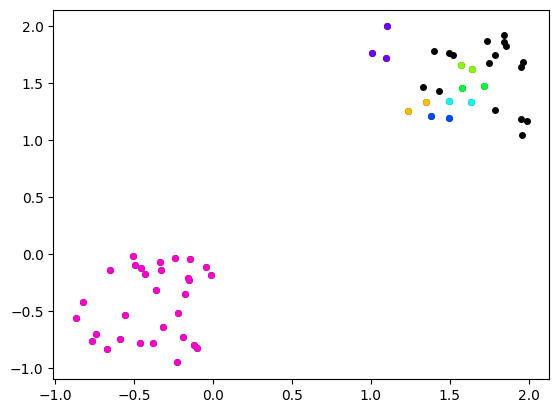

In [91]:
cmap = mpl.colormaps['hsv']

nb_clusters = sum(MM[:,0])

fig, ax = plt.subplots()
ax.plot(X[:,0], X[:,1], 'ko', markersize=4)
clu = 0
for i in range(len(mat)):
    if MM[i,0]:
        clu += 1
        for j in range(g.V):
            if mat[i, j + 6]:
                ax.plot(X[j,0], X[j,1], markersize=4, color=cmap(clu / (nb_clusters+1)), marker='o')

In [25]:
print(nb_clusters)

7.0


In [71]:
mat_adjency = np.zeros((len(mat), g.V ** 2), dtype=bool)

In [72]:
for i in range(len(mat)):
    a = np.expand_dims(mat[i, 6:], axis=0)
    mat_adjency[i,:] = (a.T @ a).flatten().astype(bool)

In [73]:
mat_adjency

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
MM

In [ ]:
W

In [ ]:
np.array([[1,2,3],[4,5,6]]).flatten().reshape(2,3)

In [ ]:
#a = np.random.rand(10,10)
hierarchy = g.hierarchy

fig, ax = plt.subplots()
container = []

ax.plot(X[:,0], X[:,1], 'ro', markersize=4)
#for v in hierarchy:
#    plt.plot(X[v[-1][0],0], X[v[-1][1],1])
#    plt.pause(0.01)

for v in hierarchy:
    line, = ax.plot(X[v[-1][:2]][:,0], X[v[-1][:2]][:,1])
    if len(container) > 0:
        container.append(container[-1] + [line])
    else: 
        container.append([line])
ani = animation.ArtistAnimation(fig, container, interval=400, blit=False)

writergif = animation.PillowWriter(fps=10)
ani.save('filename.gif',writer=writergif)

plt.show()